# Imports

In [1]:
import os

import pandas as pd
from matplotlib import pyplot as plt

# Data

In [2]:
%%capture

from djimaging.user.alpha.utils import database
from djimaging.user.alpha.schemas.alpha_schema import *

indicator = 'glutamate'
database.connect_dj(indicator=indicator)

# Select data

# Plot

In [3]:
from alphaanalysis import plot as plota

plota.set_default_params(kind='paper')

In [4]:
FIGURE_FOLDER = './figures/'

# Select example cells

In [5]:
#cell_key = dict(date="2020-11-10", exp_num=2)
cell_key = dict(date="2020-11-03", exp_num=1)

## Plot field

In [6]:
field_keys = (Field & cell_key & [dict(field=f) for f in (Field() & cell_key).fetch('field') if len(f) == 2]).fetch(
    'KEY')

In [7]:
example_key = field_keys[0]

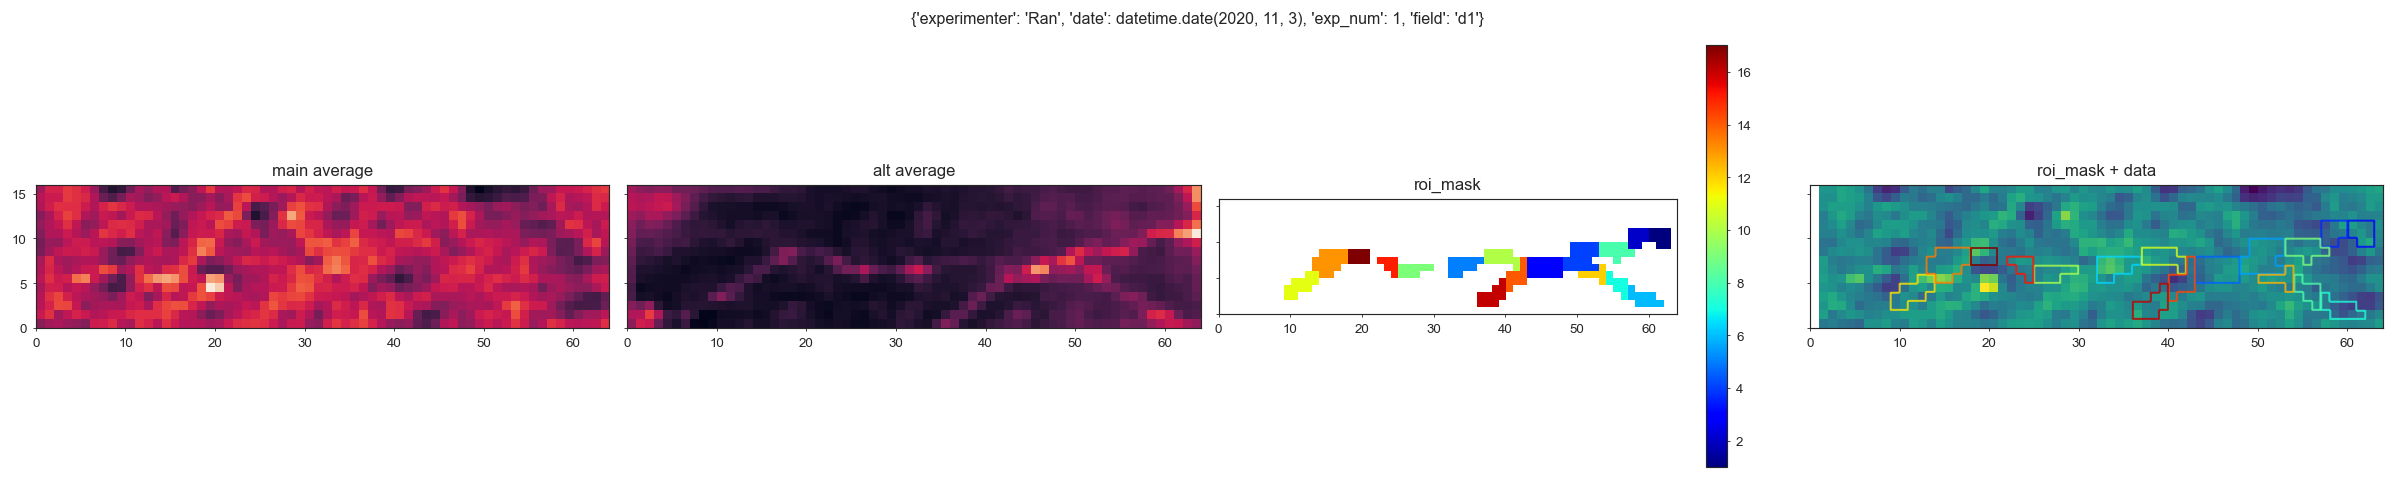

In [8]:
(Field & example_key).plot1()

In [9]:
h5_file, pixel_size_um = (Field & example_key).fetch1('fromfile', 'pixel_size_um')

In [10]:
import h5py

with h5py.File(h5_file, 'r') as file:
    print(file.keys())

    rois = -file['ROIs'][:]
    roi_corr_matrix = file['ROI_CorrMatrix'][:]
    ch0_stack = file['wDataCh0'][:]
    ch1_stack = file['wDataCh1'][:]

    ch1_std = file['wDataCh1_SD'][:]

dendr_mask = np.any(roi_corr_matrix > 0, axis=2)
ch0_std = np.std(ch0_stack, axis=2, ddof=1)

ch0_std /= np.mean(ch0_std)
ch1_std /= np.mean(ch1_std)

<KeysViewHDF5 ['GeoC', 'NoiseArray3D', 'OS_Parameters', 'ROI_CorrMatrix', 'ROIs', 'Traces0_raw', 'Traces0_znorm', 'Tracetimes0', 'Triggertimes', 'Triggervalues', 'wDataCh0', 'wDataCh1', 'wDataCh1_SD', 'wDataCh2', 'wParamsNum', 'wParamsStr']>


In [11]:
data = ch0_std.copy()
data[~dendr_mask] = 0
flat_data = data.flatten()
brightest_indices = np.argpartition(flat_data, -100)[-100:]

brightest100 = np.zeros_like(ch0_std, dtype=bool)
brightest100.flat[brightest_indices] = True

In [12]:
roi1_corr_map = roi_corr_matrix[:, :, 1].copy()
roi1_corr_map[~dendr_mask] = -1
roi1_corr_map_min = np.nanmin(roi1_corr_map[dendr_mask])
roi1_corr_map_max = np.nanmax(roi1_corr_map[(roi1_corr_map != 1) & dendr_mask])

In [13]:
from matplotlib.colors import LinearSegmentedColormap

cmap_km = LinearSegmentedColormap.from_list('kv', ['black', 'magenta'], N=256)
cmap_kg = LinearSegmentedColormap.from_list('kg', ['black', 'lime'], N=256)

cmap_rois = plt.get_cmap('tab20')
cmap_rois.set_under((0, 0, 0, 1))

cmap_corr = plt.get_cmap('viridis')
cmap_corr.set_under((0, 0, 0, 1))
cmap_corr.set_over('red')

x0, y0 = np.where(roi1_corr_map == 1)[::-1]

In [14]:
def plot_image_and_colorbar(ax, cax, im, cmap, cbar=True, label=None, pixelsize=None, c_bar='w', title=None, **kwargs):
    if title is not None:
        ax.set_title(title, fontsize=plt.rcParams['font.size'])

    im_ = ax.imshow(np.fliplr(im), cmap=cmap, origin='lower', interpolation='none', **kwargs, clip_on=False)
    ax.set(xticks=[], yticks=[])
    ax.axis('off')
    if cbar:
        plt.colorbar(im_, cax=cax, orientation='horizontal', label=label)
    else:
        cax.axis('off')

    if pixelsize is not None:
        plota.plot_scale_bar(ax=ax, x0=im.shape[1] - 1.5 - 10 * pixelsize, y0=0.5, size=10 * pixelsize, color=c_bar)

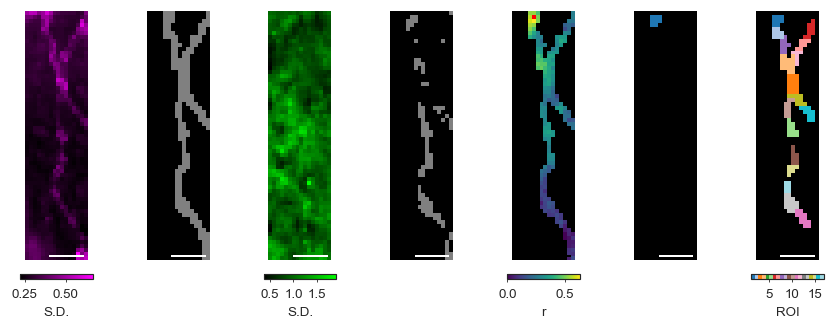

In [15]:
fig, axs = plt.subplots(2, 7, figsize=(7, 2.8), height_ratios=(50, 1), sharey='row')

plot_image_and_colorbar(axs[0, 0], axs[1, 0], ch1_std[1:], cmap_km, label='S.D.', pixelsize=pixel_size_um)
plot_image_and_colorbar(axs[0, 1], axs[1, 1], dendr_mask[1:], 'gray', vmin=0, vmax=2, cbar=False,
                        pixelsize=pixel_size_um)

plot_image_and_colorbar(axs[0, 2], axs[1, 2], ch0_std[1:], cmap_kg, label='S.D.', pixelsize=pixel_size_um)
plot_image_and_colorbar(axs[0, 3], axs[1, 3], brightest100[1:], 'gray', vmin=0, vmax=2, cbar=False,
                        pixelsize=pixel_size_um)

plot_image_and_colorbar(axs[0, 4], axs[1, 4], roi1_corr_map[1:], cmap_corr, cbar=True, label='r',
                        vmin=0, vmax=roi1_corr_map_max, pixelsize=pixel_size_um, c_bar='k')
#axs[0, 4].plot(x0, y0-1, 'ro', zorder=10, clip_on=False, mfc='none', ms=3)
plot_image_and_colorbar(axs[0, 5], axs[1, 5], rois[1:, :] == 1, cmap_rois, cbar=False, vmin=1, vmax=2, label='ROI',
                        pixelsize=pixel_size_um)
plot_image_and_colorbar(axs[0, 6], axs[1, 6], rois[1:, :], cmap_rois, cbar=True, vmin=1, label='ROI',
                        pixelsize=pixel_size_um)

plt.tight_layout(w_pad=3)

fig.savefig(os.path.join(FIGURE_FOLDER, f'ROI_mapping_{indicator}.pdf'), bbox_inches='tight', dpi=400)

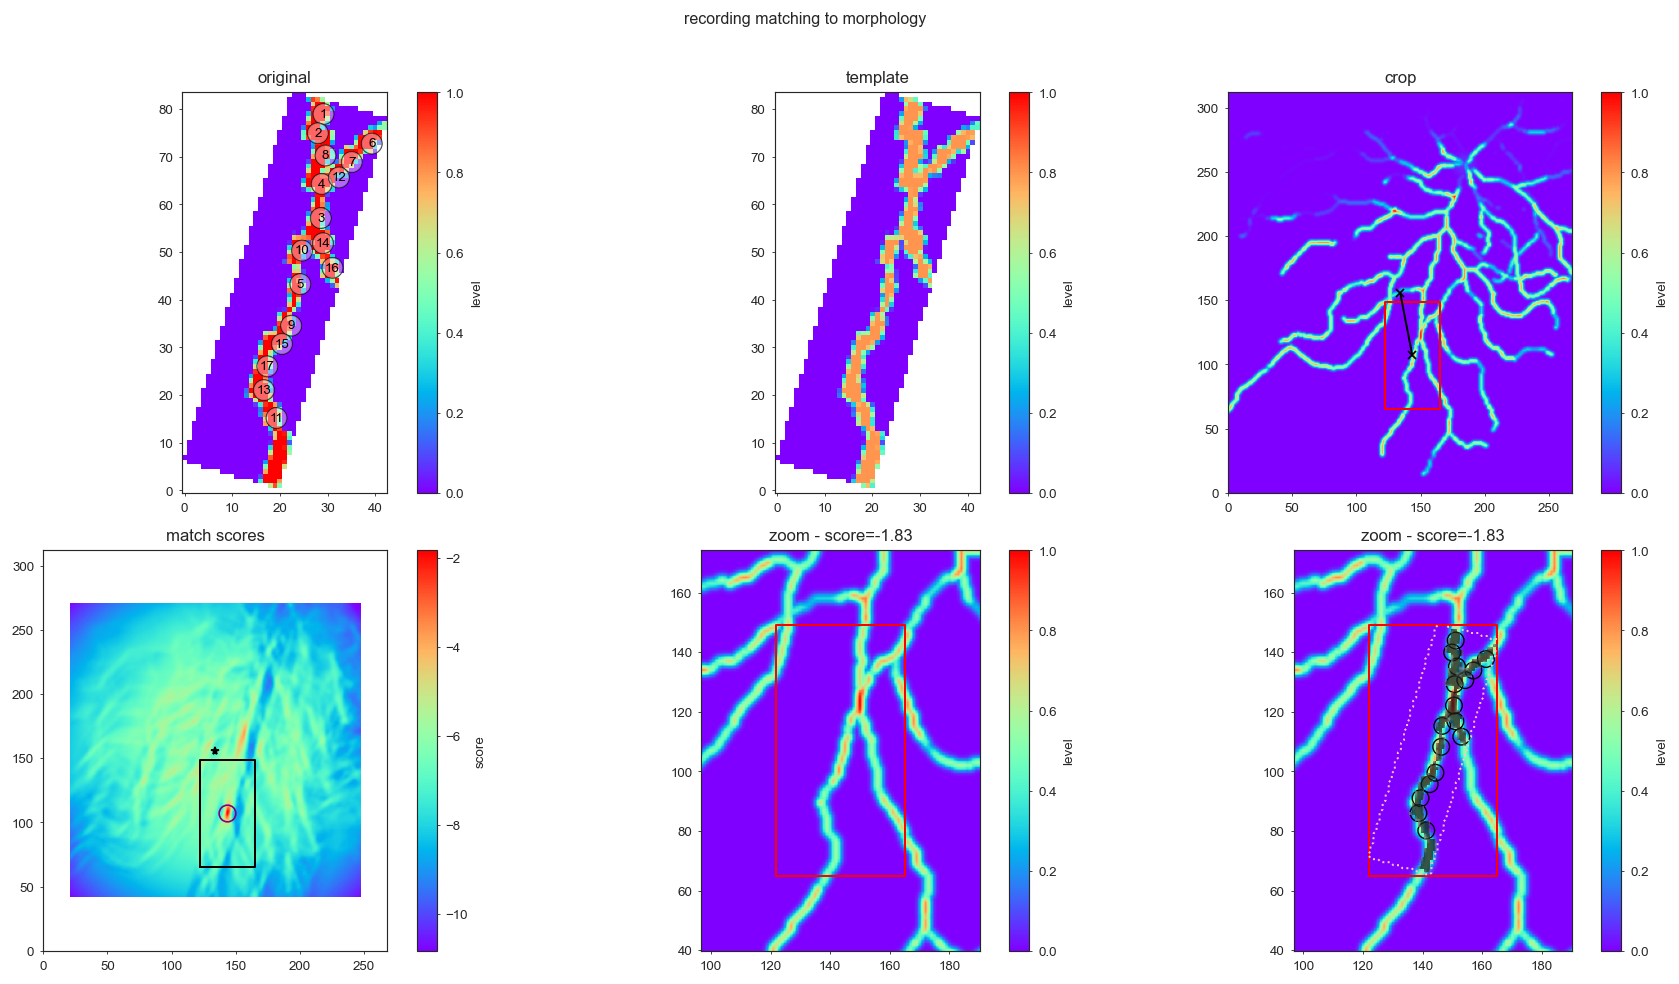

In [16]:
(FieldStackPos() & example_key).plot1()

# Plot stacks

In [17]:
morph_tab = database.get_morph_tab()

## Raw

In [18]:
print((Experiment.ExpInfo() & cell_key).fetch1('setupid', 'eye'))

('1', 'left')


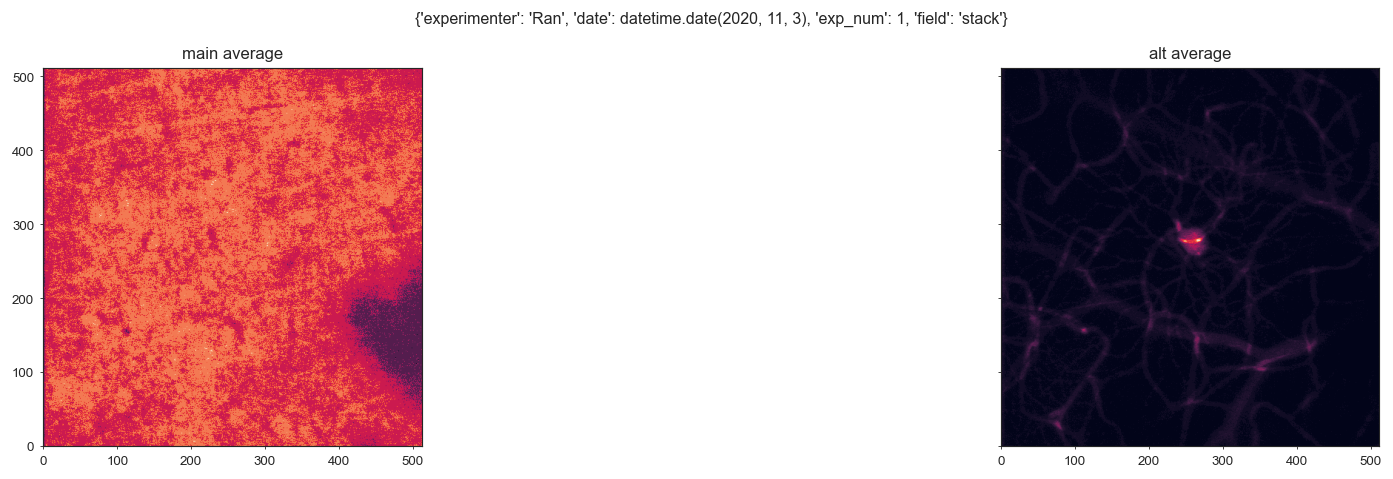

In [19]:
(Field & LineStack & cell_key).plot1()
# Left (light artifact) means temporal retina (because left eye)
# Top mean dorsal retina
# Setup does not actually matter here

## Steps

In [20]:
linestack = (LineStack & cell_key).fetch1('linestack')
linestack.shape

(512, 512, 80)

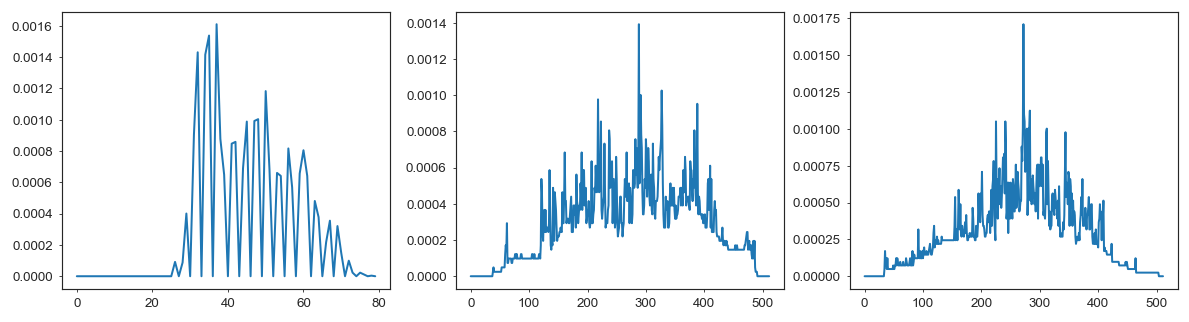

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(np.mean(linestack, axis=(0, 1)))
axs[1].plot(np.mean(linestack, axis=(0, 2)))
axs[2].plot(np.mean(linestack, axis=(1, 2)))
plt.show()

In [22]:
from djimaging.utils import scanm_utils


def get_norm_stack(filepath, q1_low=7.5, q1_high=0.025, q2_low=0.5, q2_high=5):
    ch_stacks = scanm_utils.load_stacks_from_h5(filepath)[0]
    norm_stack0 = plota.normalize_stack(ch_stacks['wDataCh0'], q_low=q1_low, q_high=q1_high)
    norm_stack1 = plota.normalize_stack(ch_stacks['wDataCh1'], q_low=q2_low, q_high=q2_high)
    return norm_stack0, norm_stack1

In [23]:
norm_stack_kw = dict(q2_low=60, q2_high=0.1, q1_low=0.5, q1_high=0.0001)
proj_z_kw = dict(gamma1=1., gamma0=0.8, gammaz=2., offz=1.)

In [24]:
filepath, pixel_size_stack = (database.Field() & cell_key & dict(field='stack')).fetch1('fromfile', 'pixel_size_um')
norm_stack0, norm_stack1 = get_norm_stack(filepath, **norm_stack_kw)

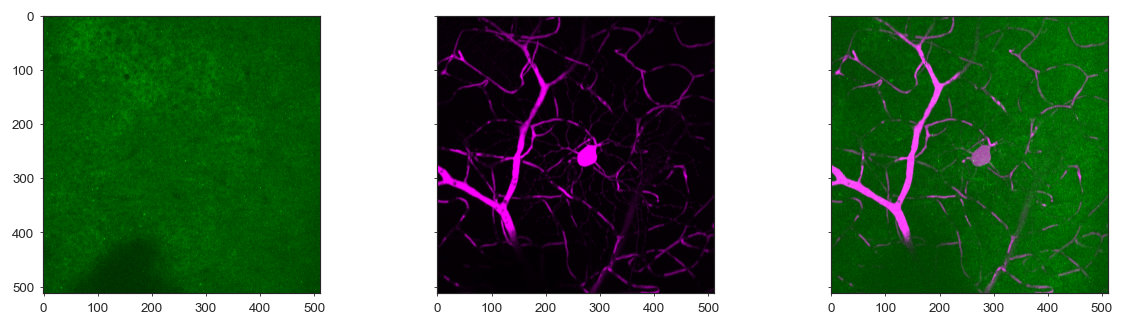

In [25]:
col_z_proj, col_stacks = plota.get_col_z_proj(norm_stack0, norm_stack1, **proj_z_kw, plot=True, return_col_stacks=True);

## Summary

In [26]:
rec_cpos_stack_xyz = (FieldStackPos() & example_key).fetch1('rec_cpos_stack_xyz')
cpos_um = rec_cpos_stack_xyz * pixel_size_stack

angle_deg = (Presentation.ScanInfo() & example_key & "stim_name='noise_1500' or stim_name='noise_2500'").fetch1('angle_deg')

In [27]:
def plot_box(ax, center, width, height, angle, color='red', linestyle='-'):
    import matplotlib.patches as patches
    rect = patches.Rectangle((center[0] - width / 2, center[1] - height / 2), width, height, fill=False,
                             edgecolor=color, angle=angle, rotation_point='center', linestyle=linestyle, clip_on=False)
    ax.add_patch(rect)

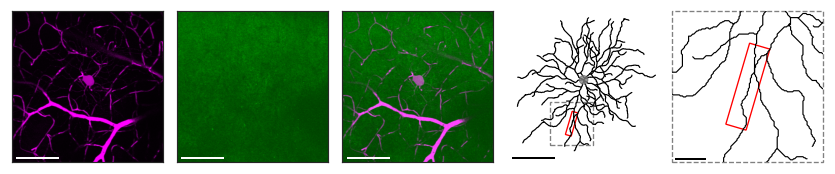

In [28]:
fig, axs = plt.subplots(1, 5, figsize=(7, 2))

ax = axs[0]
plota.plot_col_z_proj(ax, plota.proj_z_col_stack(col_stacks[1], gammaz=proj_z_kw['gammaz'], offz=proj_z_kw['offz']),
                      n_artifact=0, pixel_size_um=pixel_size_stack, center=False)
plota.plot_scale_bar(ax, x0=10, y0=10, size=100, text='', orientation='h', color='w')

ax = axs[1]
plota.plot_col_z_proj(ax, plota.proj_z_col_stack(col_stacks[0], gammaz=proj_z_kw['gammaz'], offz=proj_z_kw['offz']),
                      n_artifact=0, pixel_size_um=pixel_size_stack, center=False)
plota.plot_scale_bar(ax, x0=10, y0=10, size=100, text='', orientation='h', color='w')

ax = axs[2]
plota.plot_col_z_proj(ax, col_z_proj, n_artifact=0, pixel_size_um=pixel_size_stack, center=False)
plota.plot_scale_bar(ax, x0=10, y0=10, size=100, text='', orientation='h', color='w')

df_paths, soma_xyz = (morph_tab & cell_key).fetch1('df_paths', 'soma_xyz')
df_paths = pd.DataFrame(df_paths)
xyz_min = np.min(np.vstack(df_paths.path), axis=0)
xyz_max = np.max(np.vstack(df_paths.path), axis=0)

dxy = 50

ax = axs[-2]
plota.plot_paths(ax=ax, paths=df_paths.path, soma_xyz=soma_xyz, lw=0.7, )
ax.set_aspect('equal', 'box')
ax.axis('off')
plota.plot_scale_bar(ax, x0=10, y0=10, size=100, pad=+60, text='', orientation='h')
ax.set_xlim(0, col_z_proj.shape[0] * pixel_size_stack)
ax.set_ylim(0, col_z_proj.shape[1] * pixel_size_stack)
plot_box(ax, center=cpos_um, width=dxy * 2, height=dxy * 2, angle=0, color='gray', linestyle='--')
plot_box(ax, center=cpos_um, width=rois.shape[0] * pixel_size_um, height=rois.shape[1] * pixel_size_um, angle=angle_deg)

ax = axs[-1]
plota.plot_paths(ax=ax, paths=df_paths.path, soma_xyz=None, lw=0.7, )
ax.set_aspect('equal', 'box')
ax.axis('off')

ax.set_xlim(cpos_um[0] - dxy, cpos_um[0] + dxy)
ax.set_ylim(cpos_um[1] - dxy, cpos_um[1] + dxy)
plota.plot_scale_bar(ax, x0=cpos_um[0] + 2 - dxy, y0=cpos_um[1] + 2 - dxy, size=20, pad=+60, text='', orientation='h')
plot_box(ax, center=cpos_um, width=dxy * 2, height=dxy * 2, angle=0, color='gray', linestyle='--')
plot_box(ax, center=cpos_um, width=rois.shape[0] * pixel_size_um, height=rois.shape[1] * pixel_size_um, angle=angle_deg)

plt.tight_layout()

fig.savefig(os.path.join(FIGURE_FOLDER, f'raw_stacks_and_morph_{indicator}.pdf'), dpi=400)